-----
# NLP - Python or Java

## Getting all the libraries and defining the data processing pipeline:

In [34]:
#libraries for the data processing pipeline
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')

#libraries for training the model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer() 
en_stopwords= stopwords.words('english')

def get_wordnet_pos(token):
    """Helper function: map POS tag to first character lemmatize() accepts
    Taken from: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    """
    tag = nltk.pos_tag([token])[0][1][0].upper() #extract the information
    tag_dict = {"J": wordnet.ADJ, #map
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) #guess noun if unknown


def processing_pipeline(text):
    '''takes a sentence and returns a lowercased, lemmatized, and stemmed list of tokens'''
    tokens=nltk.word_tokenize(text)
    lemmatized_tokens=[lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    stemmed_tokens =[ps.stem(token) for token in lemmatized_tokens]
    processed_tokens = [token for token in stemmed_tokens if token not in en_stopwords] #removing stopwords/common words
    processed_tokens = [token for token in processed_tokens if token not in string.punctuation] #removing punctiuation
    return processed_tokens

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading in th data and using the data processing pipeline to process the body of the Stack Overflow posts:

In [35]:
df=pd.read_csv('data/python_or_java.csv')
df['processed_body']=df['Body'].map(processing_pipeline)

corpus= list([' '.join(text) for text in df['processed_body']])
vectorizer = TfidfVectorizer(min_df=10, max_df=.5) 
#keep only those tokens in at least 10 document, and in at most 50% of documents

DTM=vectorizer.fit_transform(corpus)
y = np.array(df.python_post) 

The response variable is the indicator of whether a post is a python post: 1 - python, 0 - java

## Test-train split of the data and training a logistic regression classifier on the training data:

In [36]:
X_train, X_test, y_train, y_test = train_test_split(DTM, y, test_size=.5, random_state=42)

reg = LogisticRegression(penalty='l1',solver='saga',C=10)
reg.fit(X_train, y_train)
y_pred = reg.predict_proba(X_test)[:,1]

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## Calculating the accuracy score and area under the curve score (AUC) in order to see how well the model perform when compared to the baseline of 0.5 which is the accuracy of always predicting that a post is a python post:

Baseline Accuracy if we always guess irrelevant: .5
Accuracy: 0.901
----------------
Confusion Matrix:
[[449  44]
 [ 55 452]]
----------------
AUC Score: 0.965


Text(0, 0.5, 'True Positive Rate')

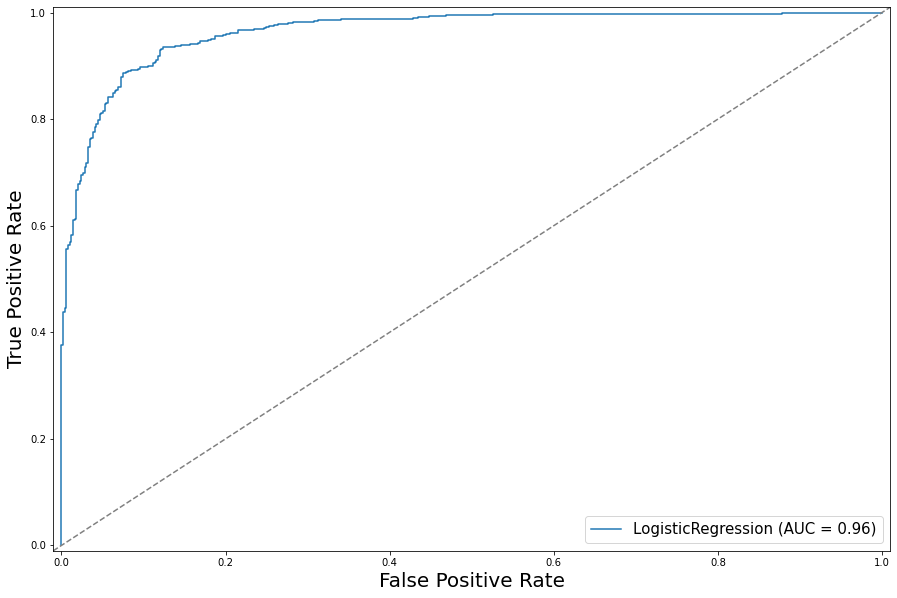

In [37]:
print('Baseline Accuracy if we always guess irrelevant: .5')
print('Accuracy: ' + str(round(accuracy_score(y_test, reg.predict(X_test)),3)))
print('----------------')
print('Confusion Matrix:')
print(confusion_matrix(y_test, reg.predict(X_test)))
print('----------------')
print('AUC Score: '+str(round(roc_auc_score(y_test,y_pred),3)))


f,ax=plt.subplots(1,figsize=(15,10))
plot_roc_curve(reg, X_test, y_test,ax=ax)
ax.plot([0, 1], [0, 1], transform=ax.transAxes,color='grey',linestyle='--')
plt.xlim([-.01,1.01])
plt.ylim([-.01,1.01])
plt.legend(prop={"size":15})
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)

The model performs much better than the baseline accuracy with an accuracy score of approximately 90% which means that the model classifies 90% of the posts correctly. The remaining 10% are false positives and false negative - see the confusion matrix. Moreover, the AUC measure is quite high as well which tells us that a randomly selected python post has a much higher probability of being a python post with the logistic regression model than a randomly selected java post.

## Getting the top 10 features of python and java posts:

In [38]:
top_positive_coefficients = pd.Series(reg.coef_[0]).sort_values(ascending=False).head(10)
top_negative_coefficients = pd.Series(reg.coef_[0]).sort_values(ascending=False).tail(10)

### Top suggestive features of Python

In [39]:
for x in top_positive_coefficients.index:
    print(vectorizer.get_feature_names()[x])

python
def
self
modul
print
django
function
re
model
element


### Top suggestive features of Java

In [40]:
for x in top_negative_coefficients.index:
    print(vectorizer.get_feature_names()[x])

int
void
kindli
netbean
eclips
privat
android
public
new
java
